TODO: TensorRT
* https://github.com/huggingface/diffusers/blob/main/examples/community/README.md#tensorrt-text2image-stable-diffusion-pipeline
* https://github.com/huggingface/diffusers/blob/main/examples/community/stable_diffusion_tensorrt_txt2img.py
* https://github.com/NVIDIA/TensorRT/tree/main/demo/Diffusion
* https://www.cerebrium.ai/blog/improve-stable-diffusion-inference-by-50-with-tensorrt-or-aitemplate
https://github.com/facebookincubator/AITemplate/tree/main/examples/05_stable_diffusion




In [1]:
%%capture

# %pip install diffusers==0.17.1
# %pip install --upgrade transformers accelerate
# %pip install tomesd
# %pip install xformers
# %pip install torchsde

from PIL import Image
from IPython.display import display

import torch
from diffusers import DiffusionPipeline, StableDiffusionPipeline
SD1_5 = "runwayml/stable-diffusion-v1-5"

from diffusers import EulerAncestralDiscreteScheduler

pipe = StableDiffusionPipeline.from_pretrained(
    SD1_5,

)
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

pipe_16 = StableDiffusionPipeline.from_pretrained(
    SD1_5,
    torch_dtype=torch.float16
)
pipe_16.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe_16.scheduler.config)
pipe_16 = pipe_16.to("cuda")

def inference(pipe=pipe):
  prompt = "a photo of an astronaut riding a horse on mars"
  image = pipe(
      [prompt],
      height=512,
      width=512,
      num_inference_steps=20,
      generator=torch.Generator(device="cuda").manual_seed(10),
    ).images[0]
  return image


100%|██████████| 20/20 [00:06<00:00,  2.97it/s]


CPU times: user 6.47 s, sys: 163 ms, total: 6.63 s
Wall time: 7.71 s


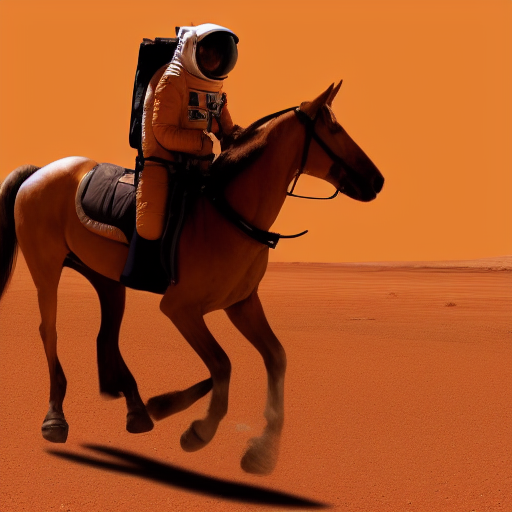

In [2]:
%%time
# NOTE: vanilla

inference()

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:05<00:00,  3.47it/s]


CPU times: user 6.05 s, sys: 48.4 ms, total: 6.1 s
Wall time: 6.09 s


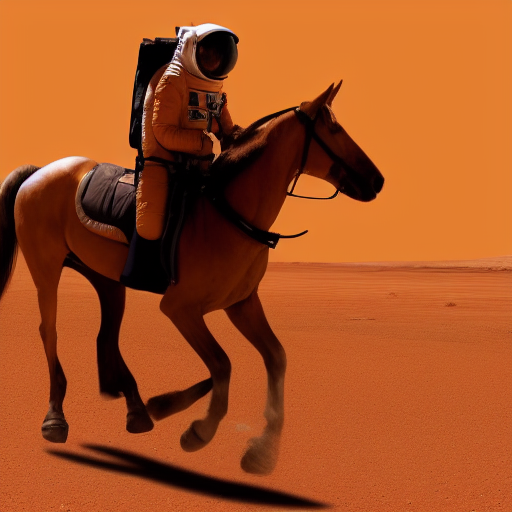

In [3]:
%%time
# NOTE: tf32

torch.backends.cuda.matmul.allow_tf32 = True
inference()

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:32<00:00,  1.61s/it]


[DEBUG] scheduler=<class 'diffusers.schedulers.scheduling_ddim.DDIMScheduler'>


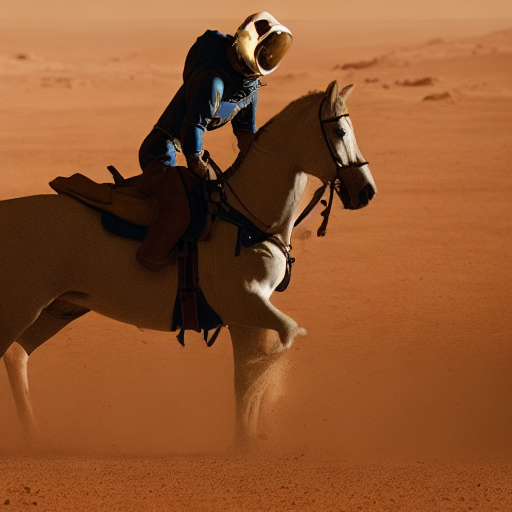

100%|██████████| 20/20 [00:32<00:00,  1.63s/it]


[DEBUG] scheduler=<class 'diffusers.schedulers.scheduling_unipc_multistep.UniPCMultistepScheduler'>


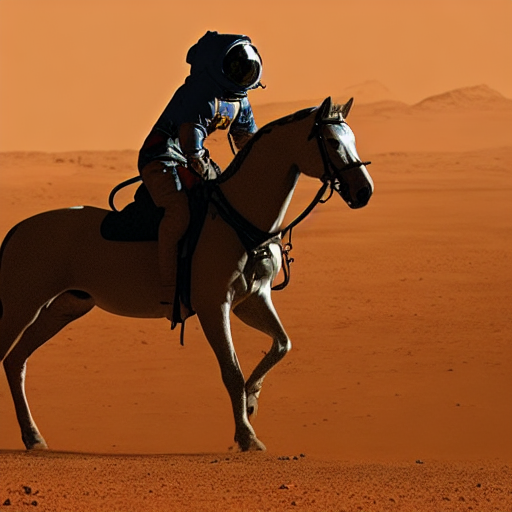

100%|██████████| 20/20 [00:32<00:00,  1.61s/it]


[DEBUG] scheduler=<class 'diffusers.schedulers.scheduling_deis_multistep.DEISMultistepScheduler'>


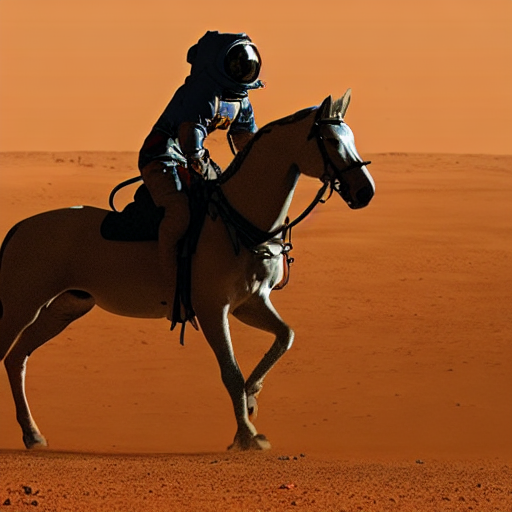

/home/theodore/anaconda3/envs/AI/lib/python3.11/site-packages/diffusers/configuration_utils.py:135: FutureWarning: Accessing config attribute `use_karras_sigmas` directly via 'DPMSolverSDEScheduler' object attribute is deprecated. Please access 'use_karras_sigmas' over 'DPMSolverSDEScheduler's config object instead, e.g. 'scheduler.config.use_karras_sigmas'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
 90%|█████████ | 18/20 [00:58<00:06,  3.25s/it]/home/theodore/anaconda3/envs/AI/lib/python3.11/site-packages/torchsde/_brownian/brownian_interval.py:585: UserWarning: Should have ta>=t0 but got ta=0.0291675366461277 and t0=0.029168.
  warnings.warn(f"Should have ta>=t0 but got ta={ta} and t0={self._start}.")
100%|██████████| 20/20 [01:03<00:00,  3.16s/it]


[DEBUG] scheduler=<class 'diffusers.schedulers.scheduling_dpmsolver_sde.DPMSolverSDEScheduler'>


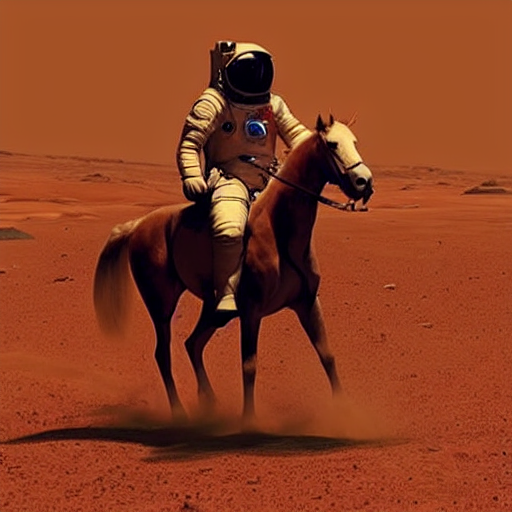

100%|██████████| 20/20 [00:32<00:00,  1.64s/it]


[DEBUG] scheduler=<class 'diffusers.schedulers.scheduling_lms_discrete.LMSDiscreteScheduler'>


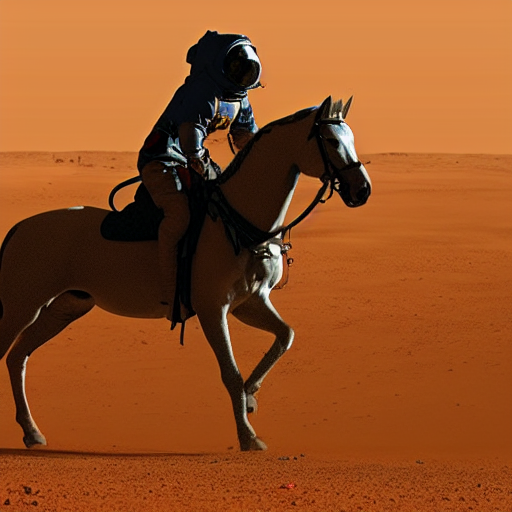

100%|██████████| 20/20 [00:32<00:00,  1.62s/it]


[DEBUG] scheduler=<class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>


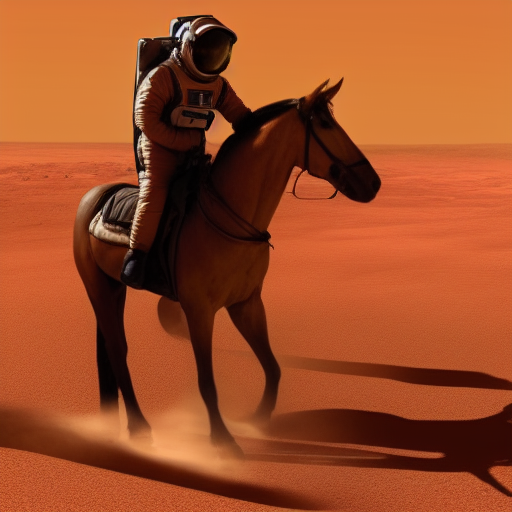

100%|██████████| 20/20 [00:31<00:00,  1.59s/it]


[DEBUG] scheduler=<class 'diffusers.schedulers.scheduling_dpmsolver_multistep.DPMSolverMultistepScheduler'>


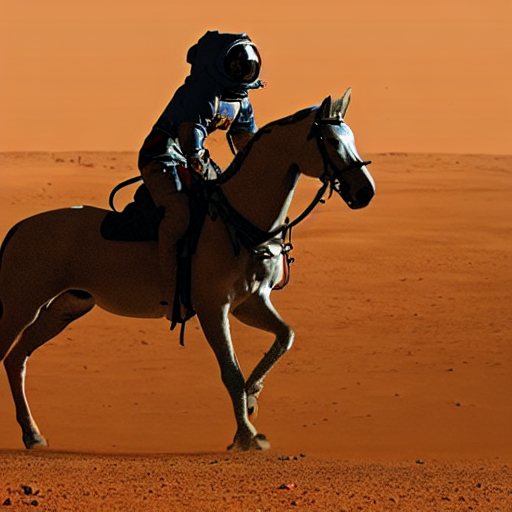

 95%|█████████▌| 19/20 [00:30<00:01,  1.61s/it]

In [4]:
%%time
# NOTE: float16

# NOTE: performance comparison among solvers
for scheduler in pipe_16.scheduler.compatibles:
  try:
    pipe_16.scheduler = scheduler.from_config(pipe_16.scheduler.config)

    image = inference(pipe_16)
    print(f"[DEBUG] {scheduler=}")
    display(image)
  except Exception as e:
    print(f"[ERROR] optimization failed with {scheduler=}!")

pipe_16.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)


In [ ]:
%%time
# NOTE: Channel last memory format
pipe_16_channel_last = StableDiffusionPipeline(**pipe_16.components)

pipe_16_channel_last.unet.to(memory_format=torch.channels_last)
inference(pipe_16_channel_last)

: 

In [ ]:
%%time
# NOTE: FlashAttention + Channel last memory format
from diffusers.models.attention_processor import AttnProcessor2_0

pipe_16_flash = StableDiffusionPipeline(**pipe_16_channel_last.components)
pipe_16_flash.unet.set_attn_processor(AttnProcessor2_0())
pipe_16_flash.unet.to(memory_format=torch.channels_last)
pipe_16_flash.unet = torch.compile(pipe_16_flash.unet, mode="max-autotune", fullgraph=True)

with torch.no_grad():
  image = inference(pipe_16_flash)


with torch.no_grad():
  image = inference(pipe_16_flash)
image

: 

In [ ]:
%%time
import tomesd

pipe_16_tomesd = StableDiffusionPipeline(**pipe_16_flash.components)
tomesd.apply_patch(pipe_16_tomesd, ratio=0.5)
#pipe_16_tomesd.unet.set_attn_processor(AttnProcessor2_0())
#pipe_16_tomesd.unet.to(memory_format=torch.channels_last)
#pipe_16_tomesd.unet = torch.compile(pipe_16_tomesd.unet, mode="max-autotune", fullgraph=True)


inference(pipe_16_tomesd)
# inference(pipe_16_tomesd)

: 

Benchmark

https://gist.github.com/sayakpaul/27aec6bca7eb7b0e0aa4112205850335


In [ ]:
import tomesd
import torch
import torch.utils.benchmark as benchmark
from diffusers import StableDiffusionPipeline


def benchmark_torch_function(f, *args, **kwargs):
    t0 = benchmark.Timer(
        stmt="f(*args, **kwargs)", globals={"args": args, "kwargs": kwargs, "f": f}
    )
    return round(t0.blocked_autorange(min_run_time=1).mean, 2)


model_id = "runwayml/stable-diffusion-v1-5"
prompt = "a photo of an astronaut riding a horse on mars"
steps = 20
num_images_per_prompt = 1
dtype = torch.float16
resolution = 512

pipe_ = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=dtype, safety_checker=None
)
pipe_.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe_.scheduler.config)
pipe_ = pipe_.to("cuda")
pipe_.set_progress_bar_config(disable=True)

# Vanilla
print("Running benchmark with vanilla pipeline...")
f = lambda: pipe_(
    prompt,
    height=resolution,
    width=resolution,
    num_inference_steps=steps,
    num_images_per_prompt=num_images_per_prompt,
).images
time_vanilla = benchmark_torch_function(f)

# With ToMe
print("Running benchmark with ToMe patched pipeline...")
tomesd.apply_patch(pipe_, ratio=0.5)
f = lambda: pipe_(
    prompt,
    height=resolution,
    width=resolution,
    num_inference_steps=steps,
    num_images_per_prompt=num_images_per_prompt,
).images
time_tome = benchmark_torch_function(f)

# With ToMe + xformers
print("Running benchmark with ToMe patched + xformers enabled pipeline...")
tomesd.remove_patch(pipe_)
pipe_.enable_xformers_memory_efficient_attention()
tomesd.apply_patch(pipe_, ratio=0.5)
f = lambda: pipe_(
    prompt,
    height=resolution,
    width=resolution,
    num_inference_steps=steps,
    num_images_per_prompt=num_images_per_prompt,
).images
time_tome_xformers = benchmark_torch_function(f)


print(
    f"Model: {model_id}, dtype: {dtype}, steps: {steps}, num_images_per_prompt: {num_images_per_prompt}, resolution: {resolution} x {resolution}"
)
print(f"Vanilla        : {time_vanilla} s")
print(f"ToMe           : {time_tome} s")
print(f"ToMe + xformers: {time_tome_xformers} s")

: 

: 